<a href="https://colab.research.google.com/github/hepi1911/ML/blob/main/Project_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

Dataset: https://www.kaggle.com/datasets/mansoordaku/ckdisease/data

In [3]:
import kagglehub as kgb

# Download latest version
path = kgb.dataset_download("mansoordaku/ckdisease")

print("Path to dataset files:", path)

100%|██████████| 9.51k/9.51k [00:00<00:00, 8.69MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mansoordaku/ckdisease/versions/1


# Data Exploration

In [4]:
df = pd.read_csv(f'{path}/kidney_disease.csv')
df

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


EDA a prendre avec enormement de precaution ( beaucoup de valeurs et d'info ) il faudra le reduire

## Missing values

       Valeurs manquantes  Pourcentage (%)
rbc                   152            38.00
rc                    130            32.50
wc                    105            26.25
pot                    88            22.00
sod                    87            21.75
pcv                    70            17.50
pc                     65            16.25
hemo                   52            13.00
su                     49            12.25
sg                     47            11.75
al                     46            11.50
bgr                    44            11.00
bu                     19             4.75
sc                     17             4.25
bp                     12             3.00
age                     9             2.25
pcc                     4             1.00
ba                      4             1.00
htn                     2             0.50
dm                      2             0.50
cad                     2             0.50
appet                   1             0.25
pe         

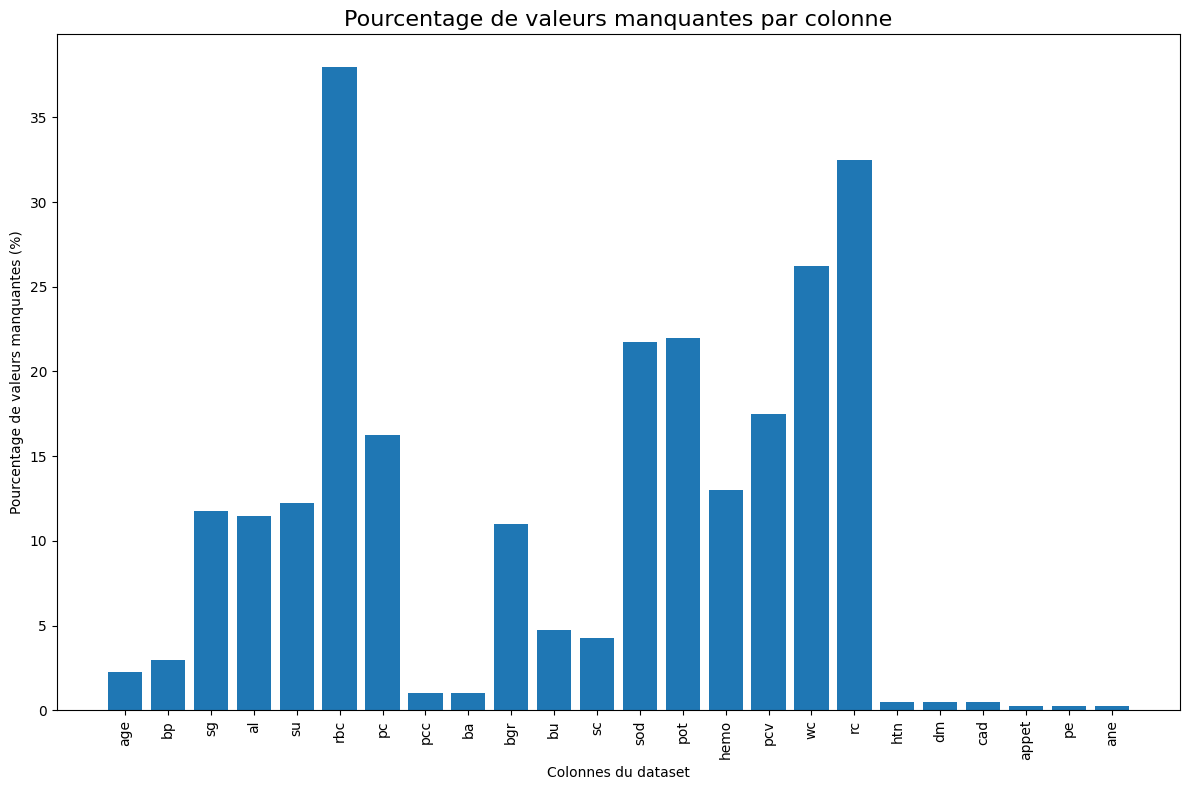

In [6]:
# 1. Analyse des valeurs manquantes
df_clean = df.replace(['\t', '?', '', 'nan', 'NaN', 'na'], np.nan)

# Compter les valeurs manquantes
missing_values = df_clean.isnull().sum()
missing_percent = (df_clean.isnull().sum() / len(df_clean)) * 100 #la ligne serait plutot missing_percent = (missing_values / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing_values,
    'Pourcentage (%)': missing_percent.round(2)
})
print(missing_df[missing_df['Valeurs manquantes'] > 0].sort_values('Pourcentage (%)', ascending=False))

# Visualisation des valeurs manquantes
plt.figure(figsize=(12, 8))
plt.title('Pourcentage de valeurs manquantes par colonne', fontsize=16)
plt.bar(missing_df[missing_df['Valeurs manquantes'] > 0].index,
        missing_df[missing_df['Valeurs manquantes'] > 0]['Pourcentage (%)'])
plt.xticks(rotation=90)
plt.ylabel('Pourcentage de valeurs manquantes (%)')
plt.xlabel('Colonnes du dataset')
plt.tight_layout()
plt.savefig('missing_values.png')

## Categorical values exploration


Distribution de 'rbc':
rbc
normal      201
NaN         152
abnormal     47
Name: count, dtype: int64

Distribution de 'pc':
pc
normal      259
abnormal     76
NaN          65
Name: count, dtype: int64

Distribution de 'pcc':
pcc
notpresent    354
present        42
NaN             4
Name: count, dtype: int64

Distribution de 'ba':
ba
notpresent    374
present        22
NaN             4
Name: count, dtype: int64

Distribution de 'pcv':
pcv
NaN     70
41      21
52      21
44      19
48      19
40      16
43      14
45      13
42      13
33      12
32      12
36      12
28      12
50      12
34      11
37      11
46       9
29       9
35       9
30       9
31       8
39       7
24       7
26       6
38       5
54       4
47       4
53       4
49       4
51       4
22       3
27       3
25       3
19       2
23       2
16       1
\t?      1
17       1
18       1
14       1
15       1
20       1
21       1
9        1
\t43     1
Name: count, dtype: int64

Distribution de 'wc':
wc
NaN     1

<ipython-input-9-dc806581a076>:16: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-dc806581a076>:17: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')



Distribution de 'cad':
cad
no      362
yes      34
\tno      2
NaN       2
Name: count, dtype: int64


<ipython-input-9-dc806581a076>:16: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-dc806581a076>:17: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')



Distribution de 'appet':
appet
good    317
poor     82
NaN       1
Name: count, dtype: int64

Distribution de 'pe':
pe
no     323
yes     76
NaN      1
Name: count, dtype: int64

Distribution de 'ane':
ane
no     339
yes     60
NaN      1
Name: count, dtype: int64

Distribution de 'classification':
classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64


<ipython-input-9-dc806581a076>:16: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-dc806581a076>:17: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')


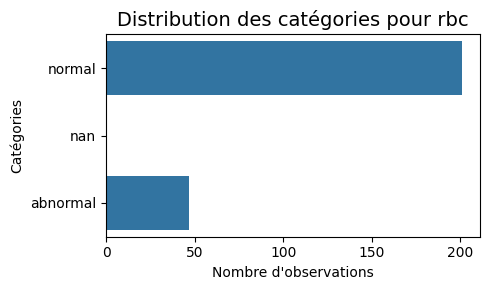

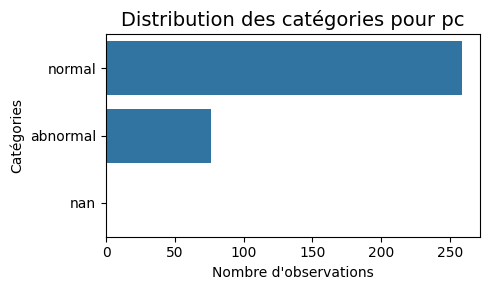

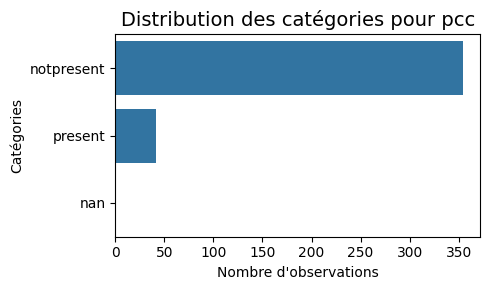

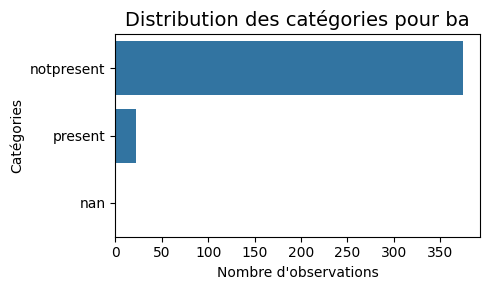

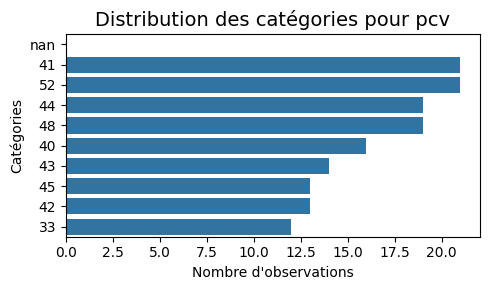

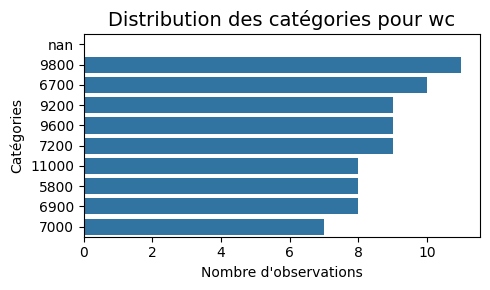

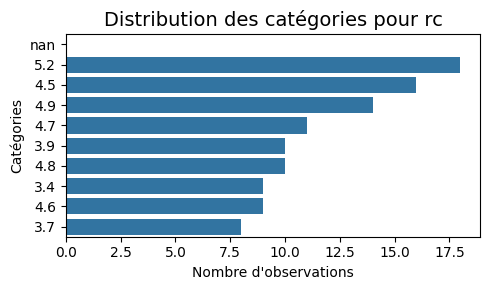

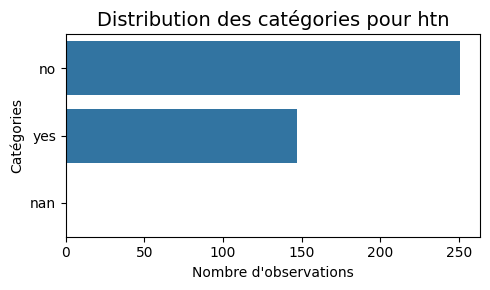

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


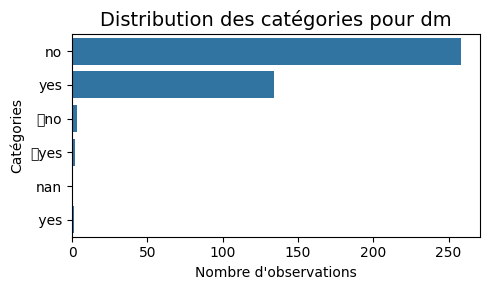

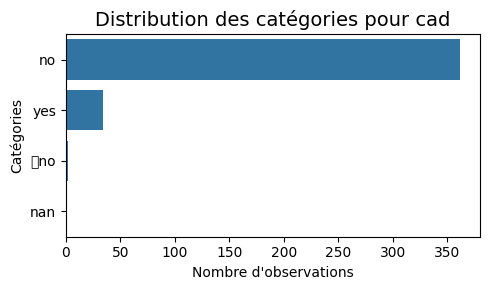

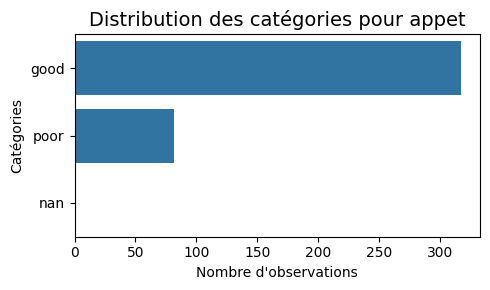

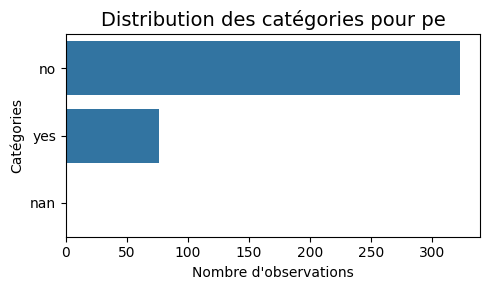

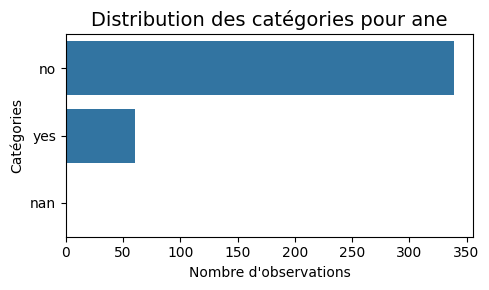

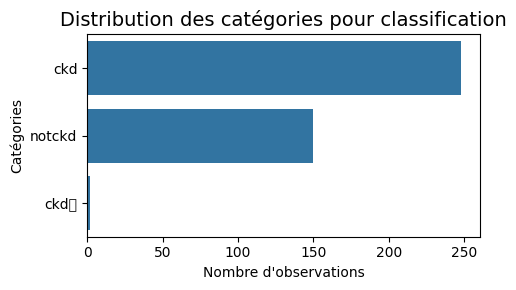

In [9]:
# 2. Analyse des variables catégorielles
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    if not pd.isna(df_clean[col]).all():
        value_counts = df_clean[col].value_counts(dropna=False)
        print(f"\nDistribution de '{col}':")
        print(value_counts)

        # Visualisation pour les variables catégorielles
        plt.figure(figsize=(15, 6))
        ax = sns.countplot(y=col, data=df_clean, order=value_counts.index[:10])
        plt.title(f'Distribution des catégories pour {col}', fontsize=14)
        plt.xlabel('Nombre d\'observations')
        plt.ylabel('Catégories')
        plt.tight_layout()
        plt.savefig(f'distribution_{col}.png')

## Numerical data exploration

In [10]:
# 3. Analyse des variables numériques
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
'''
for col in numeric_cols:
    print(f"\nStatistiques pour '{col}':")
    print(df_clean[col].describe())

    # Histogramme et boxplot
    plt.figure(figsize=(12, 6))

    # Histogramme
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean[col].dropna(), kde=True)
    plt.title(f'Distribution de {col}', fontsize=14)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_clean[col].dropna())
    plt.title(f'Boxplot de {col}', fontsize=14)
    plt.ylabel('Valeurs')

    plt.tight_layout()
    plt.savefig(f'numeric_{col}.png')
'''

'\nfor col in numeric_cols:\n    print(f"\nStatistiques pour \'{col}\':")\n    print(df_clean[col].describe())\n\n    # Histogramme et boxplot\n    plt.figure(figsize=(12, 6))\n\n    # Histogramme\n    plt.subplot(1, 2, 1)\n    sns.histplot(df_clean[col].dropna(), kde=True)\n    plt.title(f\'Distribution de {col}\', fontsize=14)\n    plt.xlabel(\'Valeurs\')\n    plt.ylabel(\'Fréquence\')\n\n    # Boxplot\n    plt.subplot(1, 2, 2)\n    sns.boxplot(y=df_clean[col].dropna())\n    plt.title(f\'Boxplot de {col}\', fontsize=14)\n    plt.ylabel(\'Valeurs\')\n\n    plt.tight_layout()\n    plt.savefig(f\'numeric_{col}.png\')\n'

## Target variable analysis

In [12]:
# 4. Analyse de la variable cible (si présente)
target_col = 'class' if 'class' in df_clean.columns else None

if target_col:
    print(f"\nDistribution de la variable cible '{target_col}':")
    print(df_clean[target_col].value_counts(dropna=False))

    # Visualisation de la variable cible
    plt.figure(figsize=(10, 6))
    target_counts = df_clean[target_col].value_counts(dropna=False)
    target_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution de la variable cible {target_col}', fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'observations')
    plt.tight_layout()
    plt.savefig('target_distribution.png')

## Correlation analysis

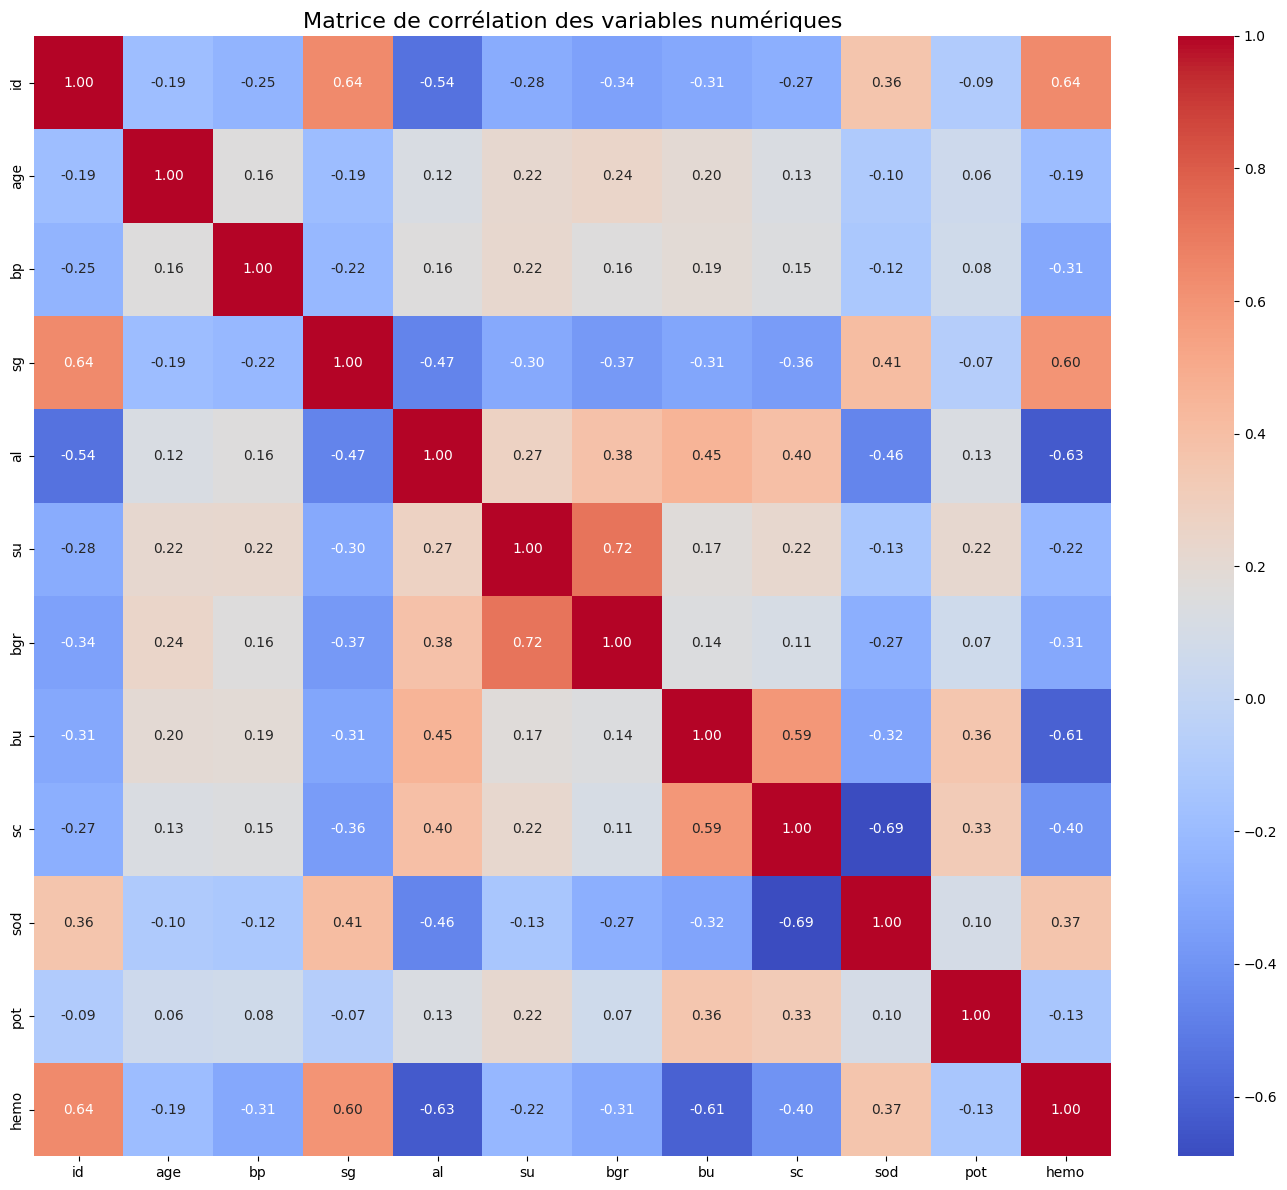

In [13]:
# 5. Analyse des corrélations
correlation_matrix = df_clean.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation des variables numériques', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png')


In [14]:
# 6. Résumé
print(f"\nDimensions: {df.shape[0]} lignes x {df.shape[1]} colonnes")
print(f"Variables catégorielles: {len(categorical_cols)}")
print(f"Variables numériques: {len(numeric_cols)}")
print(f"Colonnes avec valeurs manquantes: {sum(missing_values > 0)}")


Dimensions: 400 lignes x 26 colonnes
Variables catégorielles: 14
Variables numériques: 12
Colonnes avec valeurs manquantes: 24


# Pre-Processing

1. Conversion des données catégorielles en binaires
D'abord, nous identifions les colonnes qui contiennent des données catégorielles et les convertissons en valeurs binaires (0 et 1):

J'ai créé un dictionnaire binary_mappings qui contient les règles de conversion pour chaque colonne catégorielle connue dans le dataset kidney-disease:

Pour les colonnes comme 'rbc', 'pc': "normal" devient 1, "abnormal" devient 0
Pour 'pcc', 'ba': "present" devient 1, "notpresent" devient 0
Pour 'htn', 'dm', 'cad', 'pe', 'ane': "yes" devient 1, "no" devient 0
Pour 'appet': "good" devient 1, "poor" devient 0
Pour 'class' (la variable cible): "ckd" (chronic kidney disease) devient 1, "notckd" devient 0


Les valeurs sont d'abord nettoyées (espaces supprimés, conversion en minuscules) pour assurer la cohérence
La méthode map() de pandas est ensuite utilisée pour effectuer la conversion selon le dictionnaire défini

Cette conversion transforme les données textuelles en valeurs numériques, ce qui est essentiel pour la plupart des algorithmes de machine learning.
2. Imputation des valeurs manquantes
Après avoir converti toutes les colonnes en format numérique, nous appliquons une stratégie d'imputation en cascade pour les valeurs manquantes:

Essai avec la médiane:

Pour chaque colonne, nous calculons la médiane des valeurs existantes
La médiane est préférée à la moyenne car elle est moins sensible aux valeurs extrêmes
Si la médiane peut être calculée (assez de valeurs disponibles), nous l'utilisons pour remplacer toutes les valeurs manquantes de cette colonne


Fallback à la moyenne:

Si la médiane est elle-même NaN (peut arriver si trop peu de valeurs sont disponibles), nous essayons avec la moyenne
La moyenne est calculée et utilisée pour remplacer les valeurs manquantes


Dernier recours avec valeur par défaut:

Si ni la médiane ni la moyenne ne peuvent être calculées (par exemple, si presque toutes les valeurs sont manquantes), nous utilisons 0 comme valeur par défaut


Cas spécial des colonnes entièrement vides:

Pour les colonnes où toutes les valeurs sont manquantes, nous remplaçons directement par 0



Cette approche est progressive et adaptative, ce qui permet de traiter efficacement différents types de colonnes et différents niveaux de données manquantes.
Avantages de cette méthode

Elle est robuste face aux colonnes problématiques (comme celles mentionnées dans l'erreur : 'rbc', 'pc', 'pcc', 'ba', etc.)
Elle préserve la distribution générale des données en utilisant prioritairement la médiane
Elle garantit qu'aucune valeur manquante ne subsiste dans le dataset final, ce qui est essentiel pour la plupart des algorithmes de machine learning
La conversion binaire préalable simplifie l'interprétation future des résultats


In [15]:
# Remplacer les valeurs problématiques par NaN
df = df.replace(['\t', '?', '', 'nan', 'NaN', 'na'], np.nan)

## Conversion of categorical data into numerical

In [16]:
# Première étape : Convertir les colonnes catégorielles en binaire
# Liste des colonnes catégorielles courantes dans le dataset kidney-disease
binary_mappings = {
    'rbc': {'normal': 1, 'abnormal': 0},
    'pc': {'normal': 1, 'abnormal': 0},
    'pcc': {'present': 1, 'notpresent': 0},
    'ba': {'present': 1, 'notpresent': 0},
    'htn': {'yes': 1, 'no': 0},
    'dm': {'yes': 1, 'no': 0},
    'cad': {'yes': 1, 'no': 0},
    'appet': {'good': 1, 'poor': 0},
    'pe': {'yes': 1, 'no': 0},
    'ane': {'yes': 1, 'no': 0}
}

# Vérifier si 'class' ou 'classification' existe dans le dataframe
if 'class' in df.columns:
    binary_mappings['class'] = {'ckd': 1, 'notckd': 0}
elif 'classification' in df.columns:
    binary_mappings['classification'] = {'ckd': 1, 'notckd': 0}

# Nettoyer et standardiser les valeurs textuelles
for col in df.select_dtypes(include=['object']).columns:
    if col in df.columns and not pd.isna(df[col]).all():
        df[col] = df[col].str.strip().str.lower() if df[col].dtype == 'object' else df[col]

# Appliquer la conversion binaire
for col, mapping in binary_mappings.items():
    if col in df.columns:
        # Convertir selon le mapping
        df[col] = df[col].map(mapping)
        # Si certaines valeurs n'étaient pas dans le mapping, elles sont devenues NaN
        print(f"Conversion binaire pour {col} - valeurs NaN: {df[col].isna().sum()}")

# Tentative de conversion des autres colonnes en numérique
for col in df.columns:
    if col not in binary_mappings and df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Colonne {col} convertie en numérique")
        except:
            print(f"Échec de conversion numérique pour {col}")

Conversion binaire pour rbc - valeurs NaN: 152
Conversion binaire pour pc - valeurs NaN: 65
Conversion binaire pour pcc - valeurs NaN: 4
Conversion binaire pour ba - valeurs NaN: 4
Conversion binaire pour htn - valeurs NaN: 2
Conversion binaire pour dm - valeurs NaN: 2
Conversion binaire pour cad - valeurs NaN: 2
Conversion binaire pour appet - valeurs NaN: 1
Conversion binaire pour pe - valeurs NaN: 1
Conversion binaire pour ane - valeurs NaN: 1
Conversion binaire pour classification - valeurs NaN: 0
Colonne pcv convertie en numérique
Colonne wc convertie en numérique
Colonne rc convertie en numérique


## Data imputation

In [ ]:
# Deuxième étape : Imputation des valeurs manquantes avec la médiane pour toutes les colonnes
for col in df.columns:
    # Vérifier si la colonne contient au moins une valeur non-NaN
    if not pd.isna(df[col]).all():
        # Calculer la médiane pour toutes les colonnes (maintenant numériques)
        median_value = df[col].median()
        if pd.notna(median_value):
            df[col] = df[col].fillna(median_value)
            print(f"Colonne {col} - imputation avec médiane: {median_value}")
        else:
            # Si la médiane est NaN (peut arriver si trop peu de valeurs)
            mean_value = df[col].mean()
            if pd.notna(mean_value):
                df[col] = df[col].fillna(mean_value)
                print(f"Colonne {col} - imputation avec moyenne: {mean_value}")
            else:
                # Si tous les calculs échouent, utiliser 0
                df[col] = df[col].fillna(0)
                print(f"Colonne {col} - imputation avec 0 (par défaut)")
    else:
        # Pour les colonnes entièrement vides
        df[col] = df[col].fillna(0)
        print(f"Colonne {col} entièrement vide - remplacée par 0")

## Verifications

In [19]:


# Vérifier le résultat après nettoyage
print("\nAperçu des données après nettoyage:")
print(df.head())
print("\nInformations après nettoyage:")
print(df.info())
print("\nVérification des valeurs manquantes restantes:")
print(df.isnull().sum())

# Analyse statistique finale
print("\nStatistiques descriptives après conversion et imputation:")
print(df.describe())

# Sauvegarder le dataset nettoyé
df.to_csv('kidney_disease_cleaned_binary.csv', index=False)
print("\nFichier nettoyé sauvegardé sous 'kidney_disease_cleaned_binary.csv'")

# Option: afficher la distribution des valeurs pour vérifier
print("\nDistribution des valeurs pour quelques colonnes principales:")
for col in df.columns[:5]:  # Limité aux 5 premières colonnes
    print(f"\nDistribution de {col}:")
    print(df[col].value_counts())

# Vérification spécifique de la variable cible (class ou classification)
if 'class' in df.columns:
    print("\nDistribution de la variable cible 'class':")
    print(df['class'].value_counts())
elif 'classification' in df.columns:
    print("\nDistribution de la variable cible 'classification':")
    print(df['classification'].value_counts())

Colonne id - imputation avec médiane: 199.5
Colonne age - imputation avec médiane: 55.0
Colonne bp - imputation avec médiane: 80.0
Colonne sg - imputation avec médiane: 1.02
Colonne al - imputation avec médiane: 0.0
Colonne su - imputation avec médiane: 0.0
Colonne rbc - imputation avec médiane: 1.0
Colonne pc - imputation avec médiane: 1.0
Colonne pcc - imputation avec médiane: 0.0
Colonne ba - imputation avec médiane: 0.0
Colonne bgr - imputation avec médiane: 121.0
Colonne bu - imputation avec médiane: 42.0
Colonne sc - imputation avec médiane: 1.3
Colonne sod - imputation avec médiane: 138.0
Colonne pot - imputation avec médiane: 4.4
Colonne hemo - imputation avec médiane: 12.649999999999999
Colonne pcv - imputation avec médiane: 40.0
Colonne wc - imputation avec médiane: 8000.0
Colonne rc - imputation avec médiane: 4.8
Colonne htn - imputation avec médiane: 0.0
Colonne dm - imputation avec médiane: 0.0
Colonne cad - imputation avec médiane: 0.0
Colonne appet - imputation avec médi

Supprimer la colone Id  celle -ci me causiat des problémes sur Knn donc je la supprimer

In [ ]:
# Supprimer la colonne 'id'
df = df.drop('id', axis=1)
print("Colonne 'id' supprimée. Dimensions du dataset:", df.shape)
df

Colonne 'id' supprimée. Dimensions du dataset: (400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,1.0,1.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,1.0,1.0,0.0,0.0,121.0,...,38.0,6000.0,4.8,0.0,0.0,0.0,1.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,1.0,1.0,0.0,0.0,423.0,...,31.0,7500.0,4.8,0.0,1.0,0.0,0.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,1.0,0.0,1.0,0.0,117.0,...,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,1.0,1.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1.0,1.0,0.0,0.0,140.0,...,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,0
396,42.0,70.0,1.025,0.0,0.0,1.0,1.0,0.0,0.0,75.0,...,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,0
397,12.0,80.0,1.020,0.0,0.0,1.0,1.0,0.0,0.0,100.0,...,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,0
398,17.0,60.0,1.025,0.0,0.0,1.0,1.0,0.0,0.0,114.0,...,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,0


Ce script Python permet d'explorer en profondeur un dataset pour un projet de machine learning. En tant qu'étudiant, j'ai développé ce code pour analyser rapidement la structure et les caractéristiques d'un jeu de données avant de commencer le prétraitement et la modélisation.
Fonctionnalités
1. Informations générales
Le code commence par afficher les dimensions du dataset (nombre de lignes et de colonnes) et un aperçu des premières lignes. Cela me donne une vue d'ensemble des données avec lesquelles je vais travailler.
2. Analyse des colonnes et types de données
J'affiche ensuite la liste complète des colonnes avec leurs types de données respectifs. Cette étape est cruciale pour identifier quelles variables sont numériques, catégorielles, etc.
3. Analyse détaillée des valeurs uniques
Pour chaque colonne du dataset:

J'affiche le nombre de valeurs uniques
Si la colonne contient peu de valeurs uniques (≤ 10), je les affiche pour une inspection rapide
J'affiche la distribution des valeurs pour comprendre leur répartition
Je signale automatiquement les colonnes binaires qui pourraient servir de variables cibles

4. Identification des variables cibles potentielles
Le code recherche intelligemment les colonnes qui pourraient servir de variables cibles pour un problème de classification:

Colonnes avec un nombre limité de valeurs uniques (2-5)
Variables numériques discrètes
Affichage de leur distribution pour évaluer l'équilibre des classes

5. Vérification spécifique de la variable 'classification'
Si une colonne nommée 'classification' existe (nom commun pour une variable cible):

J'analyse spécifiquement cette colonne
Je vérifie qu'elle contient plus d'une valeur (sinon, elle ne peut pas servir à la classification)
J'affiche sa distribution détaillée

6. Recherche de colonnes liées à une classe
Le code recherche également les colonnes contenant 'class' dans leur nom, qui sont souvent des variables cibles.
7. Conclusion et recommandations
Enfin, je fournis une conclusion avec:

La recommandation de la meilleure variable cible identifiée
Une préférence pour les variables avec une distribution équilibrée des classes
Un avertissement si aucune variable cible appropriée n'est identifiée



In [ ]:
'''
# 2. Informations générales sur le dataset
print("\n--- Informations générales ---")
print(f"Dimensions: {df.shape[0]} lignes x {df.shape[1]} colonnes")
print("\nAperçu des premières lignes:")
print(df.head())
'''

'''
# 3. Vérification des noms de colonnes et types de données
print("\n--- Noms de colonnes et types de données ---")
for i, (col, dtype) in enumerate(df.dtypes.items()):
    print(f"{i+1}. {col} - {dtype}")
'''

# 4. Analyse des valeurs uniques pour chaque colonne
print("\n--- Valeurs uniques par colonne ---")
for col in df.columns:
    unique_vals = df[col].unique()
    n_unique = len(unique_vals)
    print(f"\nColonne: {col}")
    print(f"Nombre de valeurs uniques: {n_unique}")

    # Si peu de valeurs uniques, les afficher
    if n_unique <= 10:
        print("Valeurs uniques:", unique_vals)

    # Distribution des valeurs
    val_counts = df[col].value_counts()
    print("Distribution:")
    print(val_counts)

    # Vérifier si la colonne pourrait être une variable cible binaire
    if n_unique == 2:
        print("⭐️ Cette colonne pourrait être une variable cible binaire ⭐️")

# 5. Recherche des colonnes qui pourraient être des variables cibles
potential_targets = []
for col in df.columns:
    # Vérifier si la colonne a peu de valeurs uniques (idéal pour classification)
    n_unique = df[col].nunique()
    if 1 < n_unique <= 5:  # Entre 2 et 5 classes
        # Vérifier si les valeurs sont numériques et discrètes
        if df[col].dtype in ['int64', 'float64']:
            # Vérifier si les valeurs sont discrètes (pas de valeurs continuesMissingData.com)
            if len(df[col].value_counts()) <= 5:
                potential_targets.append(col)

print("\n--- Colonnes potentielles pour la variable cible ---")
for col in potential_targets:
    print(f"Colonne: {col}")
    print("Valeurs uniques:", df[col].unique())
    print("Distribution:")
    print(df[col].value_counts())
    print()

# 6. Vérification spécifique de la variable 'classification'
if 'classification' in df.columns:
    print("\n--- Analyse spécifique de la variable 'classification' ---")
    print("Valeurs uniques:", df['classification'].unique())
    print("Distribution:")
    print(df['classification'].value_counts())

    # Si 'classification' ne contient qu'une seule valeur, c'est un problème
    if df['classification'].nunique() == 1:
        print("ALERTE: La colonne 'classification' ne contient qu'une seule valeur!")
        print("Elle ne peut pas être utilisée comme variable cible pour un problème de classification.")

# 7. Vérifier la présence d'une colonne 'class' ou similaire
class_cols = [col for col in df.columns if 'class' in col.lower()]
if class_cols:
    print("\n--- Colonnes contenant 'class' dans leur nom ---")
    for col in class_cols:
        print(f"Colonne: {col}")
        print("Valeurs uniques:", df[col].unique())
        print("Distribution:")
        print(df[col].value_counts())
        print()

# 8. Conclusion et recommandations
print("\n--- Conclusion et recommandations ---")
if potential_targets:
    best_target = potential_targets[0]  # Par défaut, prenons la première
    for col in potential_targets:
        # Préférer les colonnes avec distribution plus équilibrée
        if df[col].nunique() > 1 and df[col].value_counts().min() > df[best_target].value_counts().min():
            best_target = col

    print(f"La meilleure variable cible semble être '{best_target}'")
    print("Distribution:")
    print(df[best_target].value_counts())
else:
    print("Aucune colonne appropriée pour une variable cible n'a été identifiée.")
    print("Vérifiez le processus de prétraitement des données.")


--- Informations générales ---
Dimensions: 400 lignes x 25 colonnes

Aperçu des premières lignes:
    age    bp     sg   al   su  rbc   pc  pcc   ba    bgr  ...   pcv      wc  \
0  48.0  80.0  1.020  1.0  0.0  1.0  1.0  0.0  0.0  121.0  ...  44.0  7800.0   
1   7.0  50.0  1.020  4.0  0.0  1.0  1.0  0.0  0.0  121.0  ...  38.0  6000.0   
2  62.0  80.0  1.010  2.0  3.0  1.0  1.0  0.0  0.0  423.0  ...  31.0  7500.0   
3  48.0  70.0  1.005  4.0  0.0  1.0  0.0  1.0  0.0  117.0  ...  32.0  6700.0   
4  51.0  80.0  1.010  2.0  0.0  1.0  1.0  0.0  0.0  106.0  ...  35.0  7300.0   

    rc  htn   dm  cad  appet   pe  ane  classification  
0  5.2  1.0  1.0  0.0    1.0  0.0  0.0               1  
1  4.8  0.0  0.0  0.0    1.0  0.0  0.0               1  
2  4.8  0.0  1.0  0.0    0.0  0.0  1.0               1  
3  3.9  1.0  0.0  0.0    0.0  1.0  1.0               1  
4  4.6  0.0  0.0  0.0    1.0  0.0  0.0               1  

[5 rows x 25 columns]

--- Noms de colonnes et types de données ---
1. age - 

# Model Training

Classification entre els echantillons d'entrainenemnt et ceux de test

In [ ]:

# 1. Vérification de la variable cible
print("Distribution de la variable cible 'classification':")
print(df['classification'].value_counts())
print(f"Pourcentage: {df['classification'].value_counts(normalize=True) * 100}")

# 2. Séparation des features et de la variable cible
X = df.drop('classification', axis=1)
y = df['classification']

# 3. Division en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Sauvegarde des ensembles d'entraînement et de test
X_train.to_csv('X_train.csv', index=False)
pd.Series(y_train).to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.Series(y_test).to_csv('y_test.csv', index=False)

print("\nDivision des données terminée.")
print(f"Ensemble d'entraînement : {X_train.shape[0]} échantillons ({X_train.shape[1]} caractéristiques)")
print(f"Ensemble de test : {X_test.shape[0]} échantillons ({X_test.shape[1]} caractéristiques)")
print("\nDistribution dans l'ensemble d'entraînement:")
print(y_train.value_counts())
print(f"Pourcentage: {y_train.value_counts(normalize=True) * 100}")
print("\nDistribution dans l'ensemble de test:")
print(y_test.value_counts())
print(f"Pourcentage: {y_test.value_counts(normalize=True) * 100}")

Distribution de la variable cible 'classification':
classification
1    250
0    150
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64

Division des données terminée.
Ensemble d'entraînement : 320 échantillons (24 caractéristiques)
Ensemble de test : 80 échantillons (24 caractéristiques)

Distribution dans l'ensemble d'entraînement:
classification
1    200
0    120
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64

Distribution dans l'ensemble de test:
classification
1    50
0    30
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64


Dans le cadre de notre projet de prédiction des maladies rénales chroniques (CKD), nous avons sélectionné trois algorithmes de classification ayant des approches fondamentalement différentes. Cette diversité nous permet d'explorer différentes façons d'aborder le problème et de comparer leurs performances respectives.
Justification des modèles sélectionnés
1. Régression Logistique
Pourquoi ce modèle ?

Interprétabilité : La régression logistique fournit des coefficients facilement interprétables, permettant de comprendre l'influence de chaque facteur médical sur le risque de maladie rénale.
Efficacité avec des frontières linéaires : Bien que simple, ce modèle est souvent très efficace lorsque la relation entre les variables et la classe cible peut être approximée linéairement.
Robustesse : Moins susceptible au sur-apprentissage par rapport aux modèles plus complexes, surtout avec des datasets de taille modérée.
Rapidité : Exécution rapide tant pour l'entraînement que pour les prédictions, ce qui est crucial dans un contexte médical où les décisions doivent parfois être prises rapidement.
Probabilités calibrées : Fournit des probabilités bien calibrées, ce qui est essentiel en médecine où l'incertitude de la prédiction doit être quantifiée.

2. Random Forest
Pourquoi ce modèle ?

Capture de relations complexes : Capable de modéliser des interactions non-linéaires complexes entre les variables médicales, qui sont fréquentes dans les données physiologiques.
Robustesse aux valeurs aberrantes : Les données médicales contiennent souvent des cas atypiques ou extrêmes que le Random Forest gère bien.
Importance des variables : Fournit une mesure de l'importance des caractéristiques, permettant d'identifier les facteurs médicaux les plus critiques pour le diagnostic.
Réduction du risque de sur-apprentissage : Grâce à l'agrégation de multiples arbres entraînés sur des sous-ensembles différents des données.
Performance élevée : Généralement parmi les algorithmes les plus performants pour les problèmes de classification complexes.

3. K-Nearest Neighbors (KNN)
Pourquoi ce modèle ?

Approche non-paramétrique : Ne fait aucune hypothèse sur la distribution sous-jacente des données, ce qui est avantageux pour les données médicales où les relations peuvent être difficiles à modéliser explicitement.
Intuitivité : Le concept de "similarité" avec d'autres patients est intuitif et reflète la démarche médicale de comparaison avec des cas connus.
Adaptabilité locale : S'adapte aux structures locales des données, permettant de capturer des sous-groupes spécifiques de patients présentant des caractéristiques similaires.
Pas de phase d'entraînement : Particulièrement utile lorsque de nouvelles données sont régulièrement ajoutées, car le modèle s'adapte naturellement.
Efficacité prouvée : Bien que simple, KNN peut être très efficace pour des problèmes médicaux où la proximité entre les patients dans l'espace des caractéristiques est significative.


In [ ]:
# Séparer les features et la variable cible
X = df.drop('classification', axis=1)
y = df['classification']

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisation des données avec StandardScaler
scaler = StandardScaler()

# Sélectionner uniquement les colonnes numériques pour la normalisation
numeric_features = X_train.select_dtypes(include=['number']).columns

# Ajuster le scaler uniquement sur les données d'entraînement et les transformer
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Sélection de variables (basée sur l'importance des variables du Random Forest)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Sélectionner les 10 caractéristiques les plus importantes
selected_features = feature_importance.head(10)['Feature'].tolist()

# Filtrer les dataframes avec les caractéristiques sélectionnées
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

# Entraînement des modèles

# Régression Logistique
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_selected, y_train)
y_pred_lr = lr_model.predict(X_test_selected)
y_prob_lr = lr_model.predict_proba(X_test_selected)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_selected, y_train)
y_pred_rf = rf_model.predict(X_test_selected)
y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# KNN avec optimisation
param_grid_knn = {'n_neighbors': range(1, 51), 'metric': ['euclidean']}
knn_model = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_selected, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_selected)
y_prob_knn = best_knn.predict_proba(X_test_selected)[:, 1]



Régression Logistique - Accuracy: 1.0
Random Forest - Accuracy: 1.0
KNN - Accuracy: 0.9875

Rapport de classification - Régression Logistique:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Rapport de classification - Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Rapport de classification - KNN:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1 

# Evaluation

In [ ]:
# Calculer les métriques ROC pour les visualisations
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Évaluation des modèles
print("Régression Logistique - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("KNN - Accuracy:", accuracy_score(y_test, y_pred_knn))

# Afficher les rapports de classification
print("\nRapport de classification - Régression Logistique:\n", classification_report(y_test, y_pred_lr))
print("\nRapport de classification - Random Forest:\n", classification_report(y_test, y_pred_rf))
print("\nRapport de classification - KNN:\n", classification_report(y_test, y_pred_knn))

Roc +  matrices de confusion


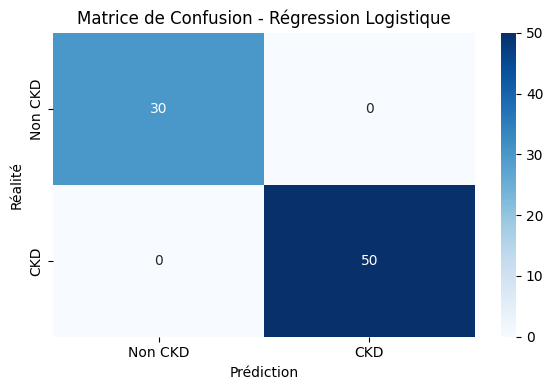

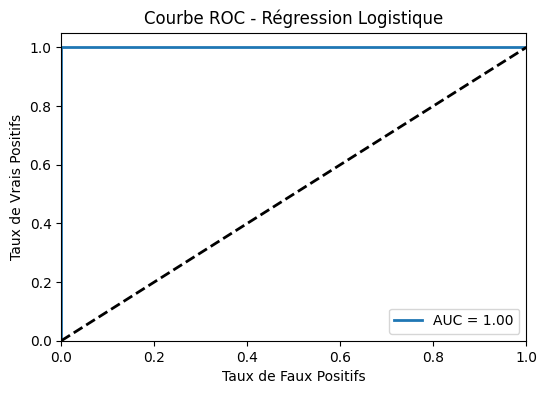

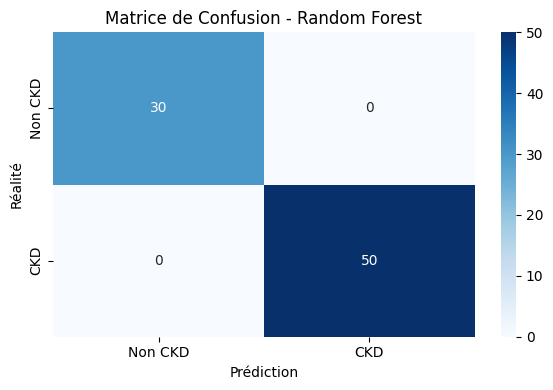

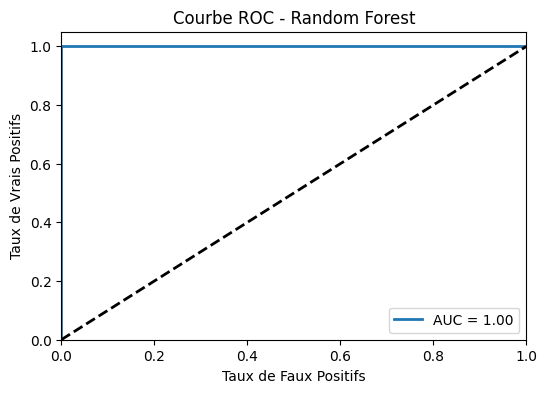

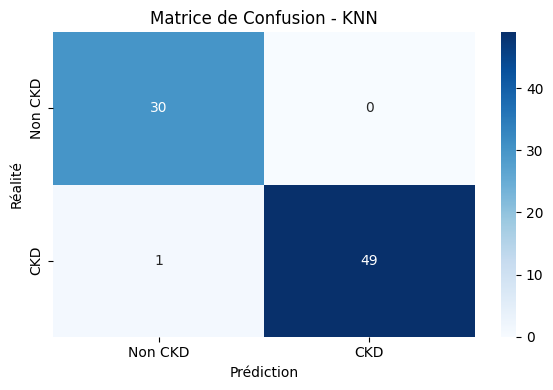

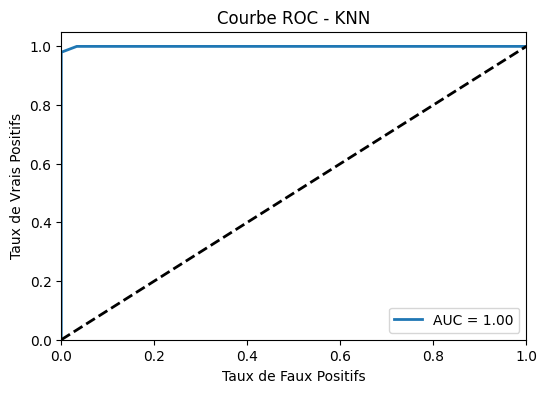

In [ ]:
plot_model_results('Régression Logistique', y_pred_lr, y_prob_lr, fpr_lr, tpr_lr, roc_auc_lr)
plot_model_results('Random Forest', y_pred_rf, y_prob_rf, fpr_rf, tpr_rf, roc_auc_rf)
plot_model_results('KNN', y_pred_knn, y_prob_knn, fpr_knn, tpr_knn, roc_auc_knn)


Pas sur si c'est utilisr mais je fais le ROC unique pour mieux analyser

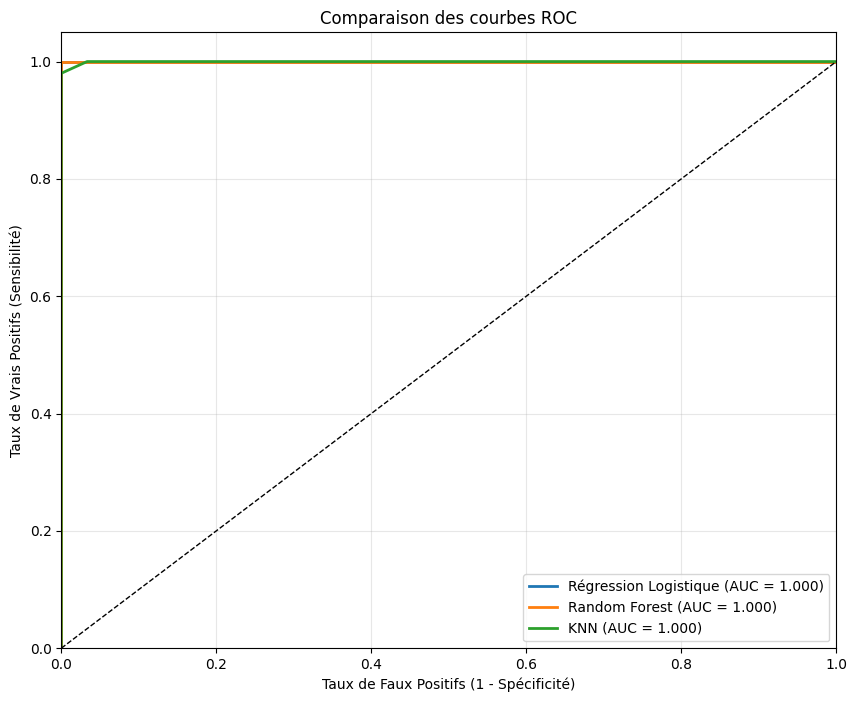

In [ ]:
# Graphique comparatif des courbes ROC
plt.figure(figsize=(10, 8))

# Courbe ROC pour la Régression Logistique
plt.plot(fpr_lr, tpr_lr, label=f'Régression Logistique (AUC = {roc_auc_lr:.3f})', linewidth=2)

# Courbe ROC pour Random Forest
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)

# Courbe ROC pour KNN
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})', linewidth=2)

# Ligne de référence (classifieur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

# Paramètres du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Comparaison des courbes ROC')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Enregistrer et afficher
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()